## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from skimage.transform import resize

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Snow Points
snow_points_gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Interpolation/Interpolaion and pre/snowpoint.shp')
snow_points = pd.DataFrame({
    'x': snow_points_gdf.geometry.x,
    'y': snow_points_gdf.geometry.y,
    'snow_depth': snow_points_gdf['SNOWDEPTH']
})

# Load Dam Line
dam_line_gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Interpolation/Interpolaion and pre/DamLine.shp')

# Load Ridges
ridges_gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Interpolation/Interpolaion and pre/ridges.shp')

# Load Elevation Raster
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/Interpolation/Interpolaion and pre/arelev1.tif") as src:
    elevation_data = src.read(1)
    transform = src.transform

In [ ]:
def plot_snow_depth(grid_x, grid_y, predicted_snow_depth, snow_points, x_min, y_min, x_max, y_max, title, colorbarlabel='Predicted Snow Depth (cm)'):
    plt.figure(figsize=(10, 8))
    plt.imshow(predicted_snow_depth, extent=(x_min, x_max, y_min, y_max), origin='upper', cmap='coolwarm')
    plt.colorbar(label=colorbarlabel)
    plt.scatter(
        snow_points['x'], snow_points['y'],
        color='black', marker='o', label='Snow Points', alpha=0.5
    )
    plt.title(title)
    plt.xlabel('Easting (meters)')
    plt.ylabel('Northing (meters)')
    plt.legend()
    plt.show()

In [ ]:
x_min, x_max = snow_points['x'].min(), snow_points['x'].max()
y_min, y_max = snow_points['y'].min(), snow_points['y'].max()
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

## Interpolation Methods

### IDW Interpolation

In [ ]:
# Apply IDW Interpolation
idw_interpolated = griddata(
    (snow_points['x'], snow_points['y']),
    snow_points['snow_depth'],
    (grid_x, grid_y),
    method='cubic'
)

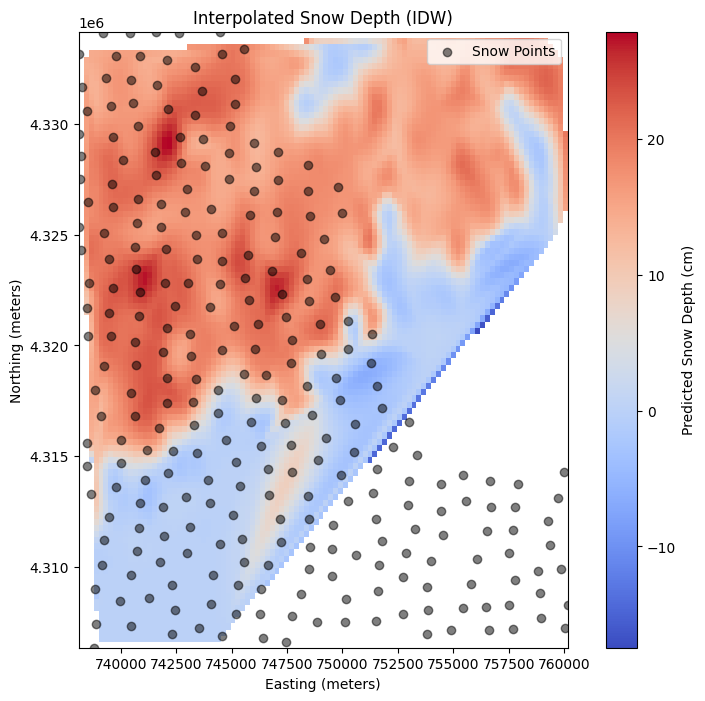

In [ ]:
# Plot IDW results
plot_snow_depth(
    grid_x, grid_y, idw_interpolated, snow_points,
    x_min, y_min, x_max, y_max, title="Interpolated Snow Depth (IDW)"
)

### Kriging Interpolation

In [ ]:
# Kriging model setup
def kriging_interpolation(snow_points, grid_x, grid_y):
    kriging_model = OrdinaryKriging(
        snow_points['x'], snow_points['y'], snow_points['snow_depth'],
        variogram_model='linear', verbose=False, enable_plotting=False
    )
    grid_z, ss = kriging_model.execute('grid', grid_x[:, 0], grid_y[0, :])
    return grid_z

snow_surface_kriging = kriging_interpolation(snow_points, grid_x, grid_y)

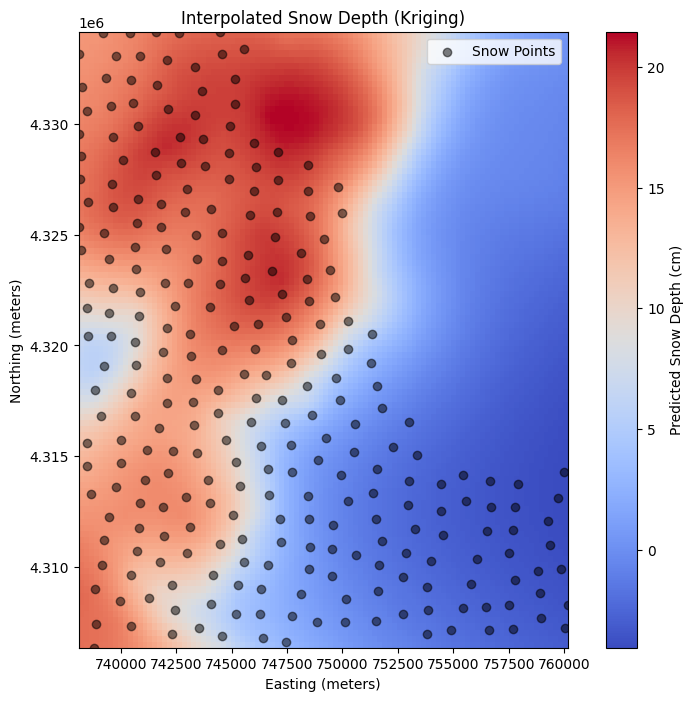

In [ ]:
plot_snow_depth(
    grid_x, grid_y, snow_surface_kriging, snow_points,
    x_min, y_min, x_max, y_max, title="Interpolated Snow Depth (Kriging)"
)


## Cross-Validation for Interpolation Comparison

In [ ]:
# Prepare data
X = snow_points[['x', 'y']]
y = snow_points['snow_depth']

# Initialize cross-validation settings
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
idw_rmse_scores = []
idw_r2_scores = []
kriging_rmse_scores = []
kriging_r2_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # IDW Interpolation
    y_pred_idw = griddata(X_train.values, y_train.values, X_test.values, method='cubic')

    # Handle NaNs in IDW predictions
    if np.isnan(y_pred_idw).any():
        y_pred_idw = np.where(np.isnan(y_pred_idw), np.nanmean(y_pred_idw), y_pred_idw)

    # Calculate RMSE and R-squared for IDW
    idw_rmse = np.sqrt(mean_squared_error(y_test, y_pred_idw))
    idw_r2 = r2_score(y_test, y_pred_idw)
    idw_rmse_scores.append(idw_rmse)
    idw_r2_scores.append(idw_r2)

    # Kriging Interpolation
    kriging_model = OrdinaryKriging(
        X_train['x'], X_train['y'], y_train,
        variogram_model='linear', verbose=False, enable_plotting=False
    )
    y_pred_kriging, _ = kriging_model.execute('points', X_test['x'], X_test['y'])

    # Handle NaNs in Kriging predictions
    if np.isnan(y_pred_kriging).any():
        y_pred_kriging = np.where(np.isnan(y_pred_kriging), np.nanmean(y_pred_kriging), y_pred_kriging)

    # Calculate RMSE and R-squared for Kriging
    kriging_rmse = np.sqrt(mean_squared_error(y_test, y_pred_kriging))
    kriging_r2 = r2_score(y_test, y_pred_kriging)
    kriging_rmse_scores.append(kriging_rmse)
    kriging_r2_scores.append(kriging_r2)

# Compute cross-validated average metrics
mean_idw_rmse = np.mean(idw_rmse_scores)
mean_idw_r2 = np.mean(idw_r2_scores)
mean_kriging_rmse = np.mean(kriging_rmse_scores)
mean_kriging_r2 = np.mean(kriging_r2_scores)

# Display results
print("Interpolation Methods Comparison:")
print(f"IDW Cross-validated RMSE: {mean_idw_rmse:.3f}")
print(f"IDW Cross-validated R-squared: {mean_idw_r2:.3f}")
print(f"Kriging Cross-validated RMSE: {mean_kriging_rmse:.3f}")
print(f"Kriging Cross-validated R-squared: {mean_kriging_r2:.3f}")


Interpolation Methods Comparison:
IDW Cross-validated RMSE: 4.823
IDW Cross-validated R-squared: 0.629
Kriging Cross-validated RMSE: 4.460
Kriging Cross-validated R-squared: 0.695


## Calculate Slope and Aspect from Elevation Data

In [ ]:
# Calculate slope and aspect from elevation raster
slope = np.degrees(np.arctan(np.sqrt(np.gradient(elevation_data, axis=0)**2 +
                                     np.gradient(elevation_data, axis=1)**2)))
aspect = np.degrees(np.arctan2(np.gradient(elevation_data, axis=1),
                               np.gradient(elevation_data, axis=0)))

# Define slope and aspect thresholds
suitable_slope = (slope >= 15) & (slope <= 30)
suitable_aspect = (aspect >= 315) | (aspect <= 45)

# Combine criteria for suitable sites
suitable_sites = suitable_slope & suitable_aspect

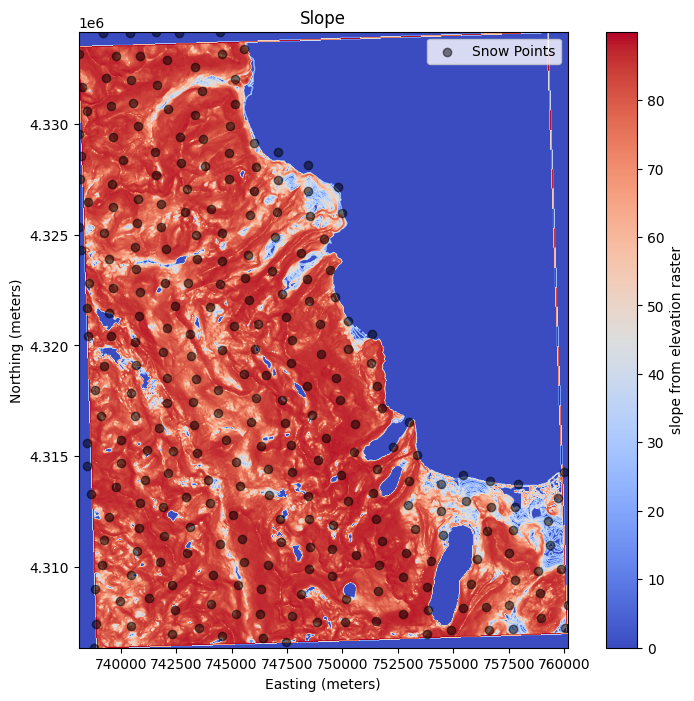

In [ ]:
plot_snow_depth(grid_x, grid_y, slope, snow_points, x_min, y_min, x_max, y_max, 'Slope','slope from elevation raster')

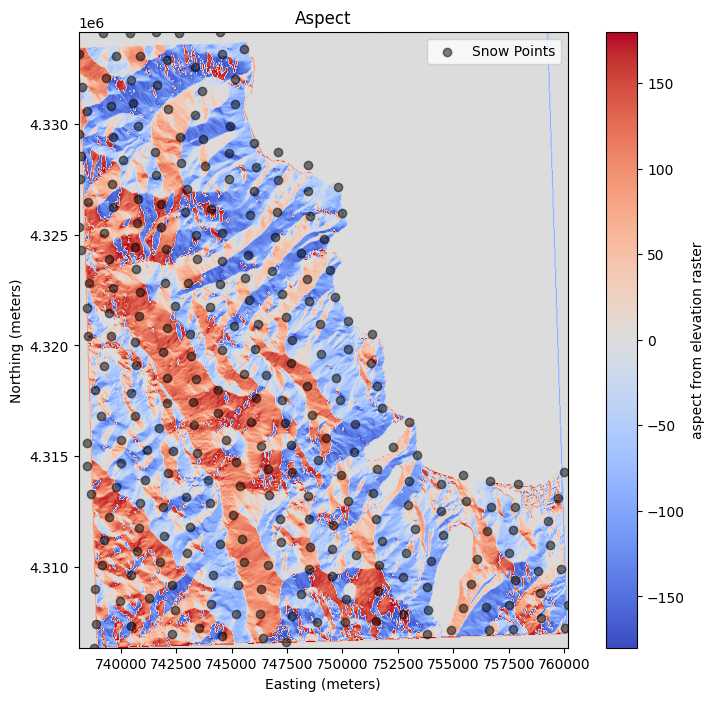

In [ ]:
plot_snow_depth(grid_x, grid_y, aspect, snow_points, x_min, y_min, x_max, y_max, 'Aspect','aspect from elevation raster')

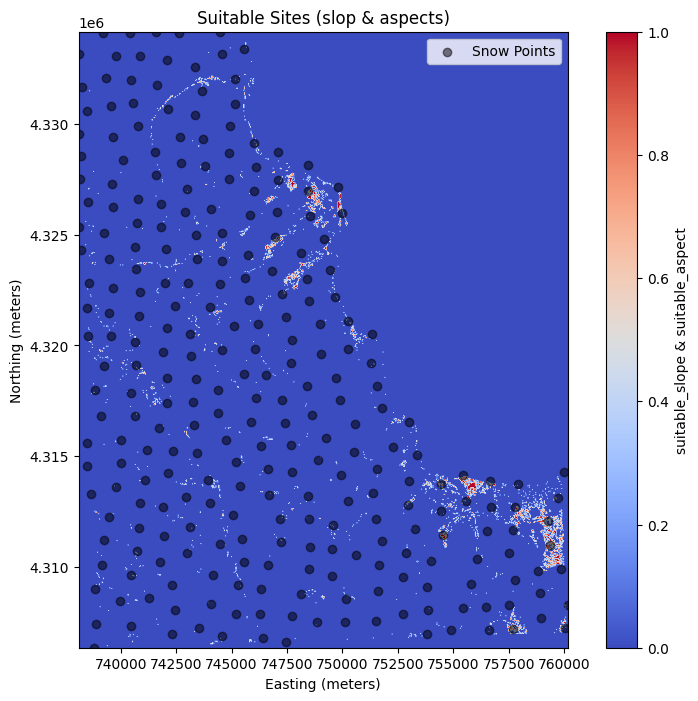

In [ ]:
plot_snow_depth(grid_x, grid_y, suitable_sites, snow_points, x_min, y_min, x_max, y_max, 'Suitable Sites (slop & aspects)','suitable_slope & suitable_aspect')

## Hillshade Calculation for Shading Analysis

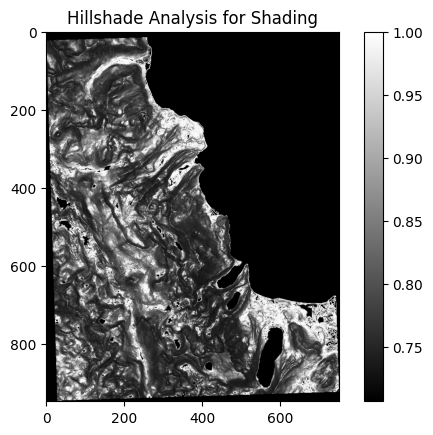

In [ ]:
hillshade = np.cos(np.radians(slope)) * np.sin(np.radians(45)) + np.sin(np.radians(slope)) * np.cos(np.radians(45))

# Plot hillshade
plt.imshow(hillshade, cmap='gray')
plt.title('Hillshade Analysis for Shading')
plt.colorbar()
plt.show()

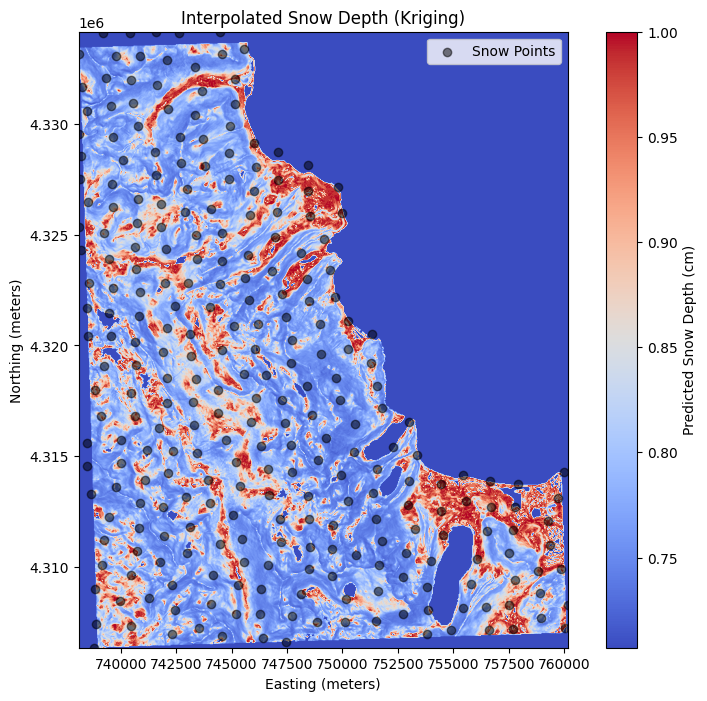

In [ ]:
plot_snow_depth(
    grid_x, grid_y, hillshade, snow_points,
    x_min, y_min, x_max, y_max, title="Interpolated Snow Depth (Kriging)"
)


## Visualize Suitable Sites for Ski Resort

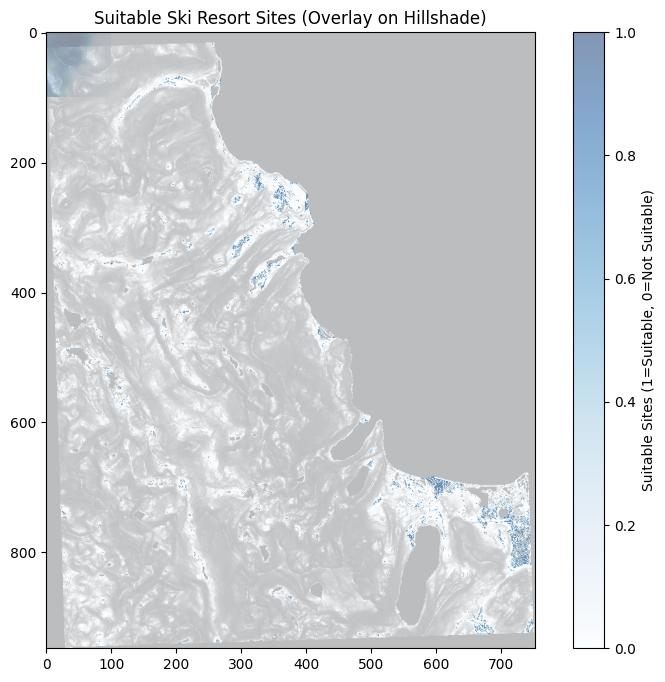

In [ ]:
# Define suitable shading (higher hillshade values represent more shaded areas)
suitable_shading = hillshade > 0.3

# Combine all criteria for suitable sites
# A site is suitable if it meets all the criteria: slope, aspect, and shading
suitable_sites = suitable_slope & suitable_aspect & suitable_shading


plt.figure(figsize=(10, 8))
plt.imshow(snow_surface_kriging, cmap='Blues', alpha=0.8)
plt.imshow(hillshade, cmap='gray', alpha=0.5)
plt.imshow(suitable_sites, cmap='Blues', alpha=0.5)

plt.title('Suitable Ski Resort Sites (Overlay on Hillshade)')
plt.colorbar(label="Suitable Sites (1=Suitable, 0=Not Suitable)")
plt.show()